In [3]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100
from torch import nn, optim
import torch.utils.data
import torchvision
from ood_metrics import auroc, plot_roc, plot_barcode

from sklearn.manifold import TSNE
import umap
import h5py


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
#                  ["cat"]))
# BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
#                  ["airplane", "automobile", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 10
INPUT_SIZE = 224
BATCH_SIZE = 128
TRAIN = False

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.train_labels[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model2.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist2.pickle', val_hist_path='val_hist2.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist2.pickle', val_hist_path='val_hist2.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

In [5]:
from sampler import ImbalancedDatasetSampler

# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'])
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'])
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'])
cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                        target_transform=lambda y: y+10)

dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [8]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

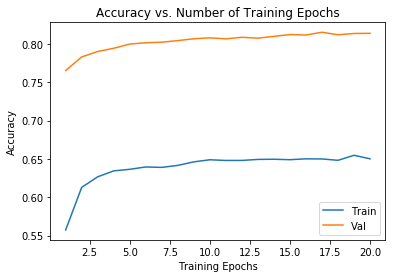

In [9]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_10.pt')
    save_history(train_hist, val_hist, 'train_hist_10.pickle', 'val_hist_10.pickle')
else:
    load_model(model, path='vgg16_10.pt')
    train_hist, val_hist = load_history('train_hist_10.pickle', 'val_hist_10.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [10]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [11]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


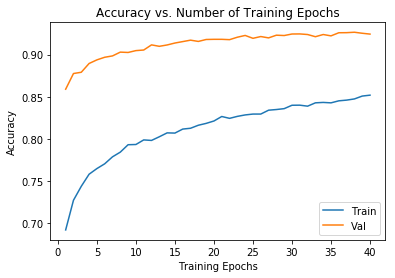

In [12]:
NUM_EPOCHS = 40
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_10_fine.pt')
    save_history(train_hist, val_hist, 'train_hist_fine_10.pickle', 'val_hist_fine_10.pickle')
    
else:
    load_model(model, path='vgg16_10_fine.pt')
    train_hist, val_hist = load_history('train_hist_fine_10.pickle', 'val_hist_fine_10.pickle')

plot_training_hist(train_hist, val_hist)

In [13]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.8787


# Train Mahalanobis Distance function

In [40]:
def penultimate_forward_densenet161(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    penultimate = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
    out = self.classifier(penultimate)
    return out, penultimate

def penultimate_forward_vgg16(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    penultimate = model.classifier[:5](x)
    out = model.classifier[5:](penultimate)
    return out, penultimate

# Bind a function to the model to extract penultimate features
model.penultimate_forward = penultimate_forward_vgg16.__get__(model)

In [41]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    model.eval()
    
    for dataset in ['train_no_aug', 'val', 'ood']:
        softmax_outputs = []
        mahalanobis_features = []
        labels_out = []  
        
        for inputs, labels in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc=dataset):
            outputs, features = model.penultimate_forward(inputs.to(device))

            softmax_outputs.append(outputs.cpu().detach().numpy())
            mahalanobis_features.append(features.cpu().detach().numpy())
            labels_out.append(labels.cpu().detach().numpy())

        # Save outputs to disk
        with h5py.File("cifar10_vgg16.h5", "a") as f:
            if dataset in f.keys():
                del f[dataset]
                
            g = f.create_group(dataset)
            g.create_dataset("softmax_outputs", data=np.concatenate(softmax_outputs, axis=0))
            g.create_dataset("mahalanobis_features", data=np.concatenate(mahalanobis_features, axis=0))
            g.create_dataset("labels", data=np.concatenate(labels_out, axis=0))

In [42]:
class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self.fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels):
        """Fit parameters used for Mahalanobis distance."""
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        mahal_means = []
        print("Calculating mahal mean")
        for l in self.labels:
            mask = gt_labels == l
            mahal_means.append(gt_features[mask].mean(axis=0))#, dtype=np.float16))
            
        self.mahal_means = np.array(mahal_means)

        x = gt_features.copy()
        print("Calculating mahal cov")
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x[mask] -= self.mahal_means[i]

        self.mahal_cov = np.dot(x.T, x) / len(gt_features)
        print("Inverting")
        self.inv_mahal_cov = np.linalg.inv(self.mahal_cov + np.eye(len(self.mahal_cov)) * 1e-10)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        x =  -self.mahal_means + features
        m_x = np.diag(-np.dot(np.dot(x, self.inv_mahal_cov), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        max_i = np.argmax(m_x, axis=0)
        return np.array([self.labels[max_i], m_x[max_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmax(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.max(self(features), axis=0)
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.mahal_means)
            g.create_dataset("cov", data=self.mahal_cov)
            g.create_dataset("inv_cov", data=self.inv_mahal_cov)
            g.create_dataset("labels", data=self.inv_mahal_cov)
            
    @classmethod
    def load(cls, fname='mahal_distance.h5'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.labels = f['mahal_distance/labels'].value
            inst.mahal_means = f['mahal_distance/means'].value
            inst.mahal_cov = f['mahal_distance/cov'].value
            inst.inv_mahal_cov = f['mahal_distance/inv_cov'].value
        
        return inst

In [43]:
if TRAIN:  
    with h5py.File("cifar10_vgg16.h5", "r") as f:
        mahalanobis_features_train = f['train_no_aug/mahalanobis_features'].value
        labels_train = f['train_no_aug/labels'].value
    
    md = Mahal_Dist()
    md.fit(mahalanobis_features_train, labels_train)
    md.save("cifar10_vgg16.h5")
else:
    md = Mahal_Dist.load("cifar10_vgg16.h5")

# Extract FG, BG, OOD Softmax predictions and Mahal features

In [32]:
with h5py.File("cifar10_vgg16.h5", 'r') as f:
    labels_val = f['val/labels'].value
    features_val = f['val/mahalanobis_features'].value    
    outputs_val = f['val/softmax_outputs'].value    

mahalanobis_label_dist_val = list(map(md.label_dist, features_val))


# Get gt_labels, predicted labels, distance to nearest mean
mahalanobis_labels_val = [x[0] for x in mahalanobis_label_dist_val]
mahalanobis_dist_val = [x[1] for x in mahalanobis_label_dist_val]

correct = np.sum((mahalanobis_labels_val == labels_val).astype(np.int))
print("%d%% of data classified correctly with mahalanobis distance" % (correct / len(labels_val) * 100))

(10000, 4096)
88% of data classified correctly with mahalanobis distance


In [33]:
with h5py.File("cifar10_vgg16.h5", 'r') as f:
    labels_ood = f['ood/labels'].value
    features_ood = f['ood/mahalanobis_features'].value
    outputs_ood = f['ood/softmax_outputs'].value    

mahalanobis_label_dist_ood = list(map(md.label_dist, features_ood))

# Get gt_labels, predicted labels, distance to nearest mean
mahalanobis_labels_ood = [x[0] for x in mahalanobis_label_dist_ood]
mahalanobis_dist_ood = [x[1] for x in mahalanobis_label_dist_ood]

In [34]:
mahalanobis_dist = np.concatenate([mahalanobis_dist_val, mahalanobis_dist_ood], axis=0)
softmax_outputs = np.concatenate([outputs_val, outputs_ood], axis=0)
labels = np.concatenate([labels_val, labels_ood], axis=0)

# Extract FG, BG, OOD MC dropout Softmax scores

In [89]:
# Setup model for dropout
model.eval()

# Set all dropout layers to train mode
def mc_dropout(m):
    if type(m) == nn.Dropout:
        print(m)
        m.train()

model.apply(mc_dropout);

In [37]:
NUM_MC_DROPOUT_RUNS = 50

if TRAIN:
    mc_softmax_outputs = [np.empty((0,NUM_CLASSES))] * NUM_MC_DROPOUT_RUNS

    # # Inlier FG and BG
    for x, y in tqdm(dataloaders_dict['val'], total=len(dataloaders_dict['val'])):
        for i in trange(NUM_MC_DROPOUT_RUNS, leave=False):
            output = model(x.cuda())
            softmax_out = F.softmax(output, dim=1)
            softmax_out = softmax_out.detach().cpu().numpy()
            mc_softmax_outputs[i] = np.concatenate((mc_softmax_outputs[i], softmax_out), axis=0)

    # Outliers OOD  
    for x, y in tqdm(dataloaders_dict['ood'], total=len(dataloaders_dict['ood'])):
        for i in trange(NUM_MC_DROPOUT_RUNS, leave=False):
            output = model(x.cuda())
            softmax_out = F.softmax(output, dim=1)
            softmax_out = softmax_out.detach().cpu().numpy()
            mc_softmax_outputs[i] = np.concatenate((mc_softmax_outputs[i], softmax_out), axis=0)
            
    mc_softmax_outputs = np.array(mc_softmax_outputs)

    with open("mc_softmax_densenet161_outputs.pickle", 'wb') as f:
        pickle.dump(mc_softmax_outputs, f)

else:
    with open("mc_softmax_densenet161_outputs.pickle", 'rb') as f:
        mc_softmax_outputs = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'mc_softmax_densenet161_outputs.pickle'

# Separating BG+FG from OOD

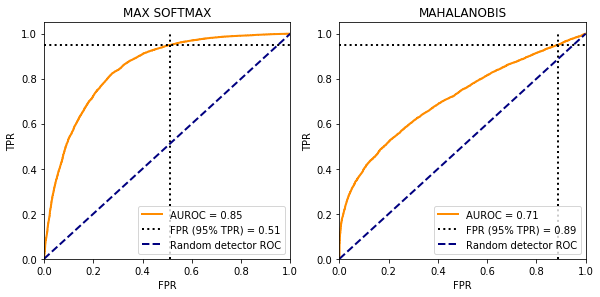

In [35]:
from sklearn.metrics import roc_curve
from ood_metrics import fpr_at_95_tpr
import mc_uncertainty as mc
from ood_metrics import calc_metrics

scores_dict ={
    "max_softmax": -softmax_outputs.max(axis=1),
    "mahalanobis": -np.array(mahalanobis_dist),
#     "max_mc_softmax": -np.max(np.mean(mc_softmax_outputs, axis=0), axis=1),
#     "mean_variance": np.mean(mc.variance(mc_softmax_outputs), axis=1),
#     "predicted_entropy": mc.predicted_entropy(mc_softmax_outputs),
#     "mutual_information": mc.mutual_information(mc_softmax_outputs)
}

plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels >= NUM_CLASSES).astype(np.int)
    
    fpr, tpr, _ = roc_curve(ood_labels, sv)
    tpr95 = fpr_at_95_tpr(sv, ood_labels)
    roc_auc = auroc(sv, ood_labels)

    plt.subplot(231+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

# Separating FG from OOD

In [118]:
# mahalanobis_predicted_distances = list(map(md, id_conv_feats)) + list(map(md, ood_conv_feats))

# mahalanobis_predicted_dist_from_fg = np.array(mahalanobis_predicted_distances)[0,:]
# mahalanobis_predicted_dist_from_bg = np.array(mahalanobis_predicted_distances)[1,:]

fg_pred_mask = softmax_outputs.argmax(axis=1).astype(np.bool)

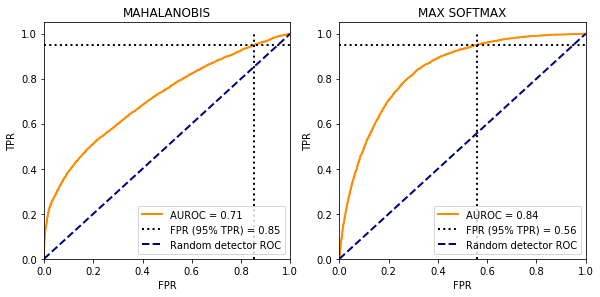

In [119]:
plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels).astype(np.int)
    
    sv = np.array(sv)[fg_pred_mask]
    lv = ood_labels[fg_pred_mask] >= NUM_CLASSES
    
    fpr, tpr, _ = roc_curve(lv, sv)
    tpr95 = fpr_at_95_tpr(sv, lv)
    roc_auc = auroc(sv, lv)

    plt.subplot(231+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

# Separating BG from OOD

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


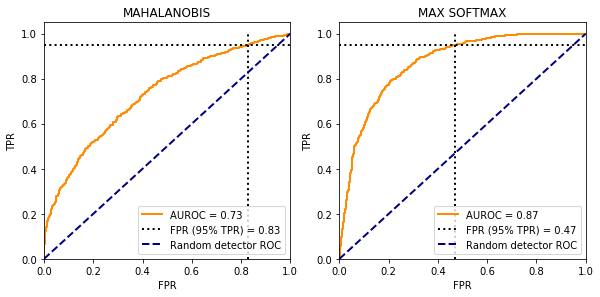

In [120]:
plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels).astype(np.int)
    sv = np.array(sv)[~fg_pred_mask]
    lv = ood_labels[~fg_pred_mask] >= NUM_CLASSES
    
    fpr, tpr, _ = roc_curve(lv, sv)
    tpr95 = fpr_at_95_tpr(sv, lv)
    roc_auc = auroc(sv, lv)

    plt.subplot(231+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()

# FIX MD

In [208]:
train_feats, train_labels = extract_penultimate_features(model, dataloaders_dict['train_no_aug'], 'vgg16')

In [254]:
class Mahal_Dist(object):
    def __init__(self, gt_features, gt_labels):
        """Initialize parameters used for Mahalanobis distance."""
        super().__init__()
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        print("Calculating mahal mean")
        self.mahal_means = []
        for l in self.labels:
            mask = gt_labels == l
            self.mahal_means.append(gt_features[mask].mean(axis=0))
        self.mahal_means = np.array(self.mahal_means)

        print("Calculating mahal covs")
        self.mahal_covs = []        
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x = gt_features[mask] - self.mahal_means[i]
            self.mahal_covs.append(np.cov(x.T))
        self.mahal_covs = np.array(self.mahal_covs)
        
        print("Inverting mahal covs")        
        self.inv_mahal_covs = []
        for x in self.mahal_covs:
            self.inv_mahal_covs.append(np.linalg.inv(x))
        self.inv_mahal_covs = np.array(self.inv_mahal_covs)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        m_x = []
        for i in range(len(self.mahal_means)):
            x = features -self.mahal_means[i]
            m_x.append(np.dot(np.dot(x, self.inv_mahal_covs[i]), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        min_i = np.argmin(m_x, axis=0)
        return np.array([self.labels[min_i], m_x[min_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmin(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.min(self(features), axis=0)
    
    def save(self, fname='mahal_distance.pickle'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with open(fname, 'wb') as f:
            pickle.dump(self, f)
    
    @classmethod
    def load(cls, fname='mahal_distance.pickle'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        with open(fname, 'rb') as f:
            obj = pickle.load(f)
        return obj
   

In [255]:
md = Mahal_Dist(train_feats, train_labels)

Calculating mahal mean
Calculating mahal covs
Inverting mahal covs


In [256]:
# Test correct classification of validation data
SUBSIZE = 1000

val_preds = list(map(md.label, mahalanobis_features_val))

In [258]:
np.sum((val_preds == test_labels).astype(np.int)) / len(val_preds)

0.42965

In [264]:
plot_roc(-val_preds, (test_labels >= NUM_CLASSES).astype(np.int))

TypeError: bad operand type for unary -: 'list'

In [46]:
with h5py.File('cifar10_vgg16.h5', 'r') as f:
    feats = f['train_no_aug/mahalanobis_features'].value
    labels_train = f['train_no_aug/labels'].value
    embedding = umap.UMAP().fit_transform(feats)

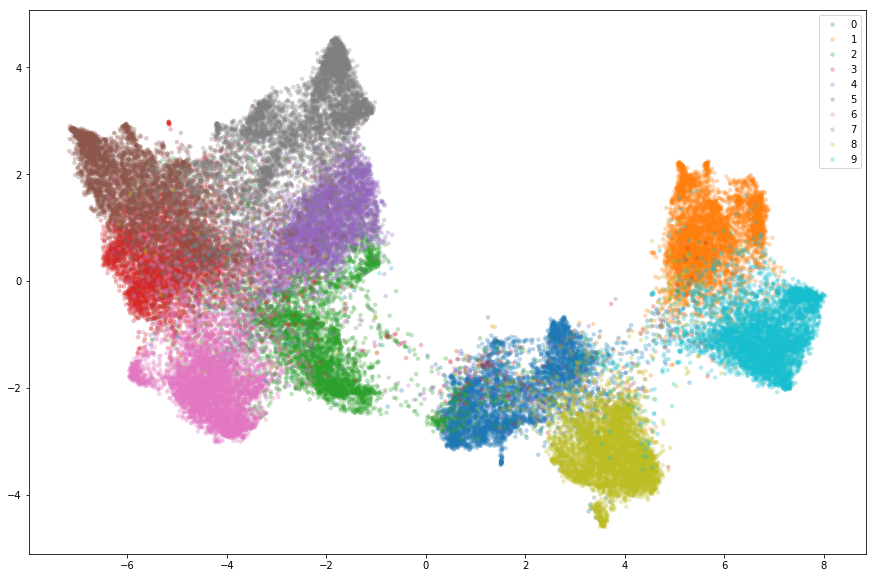

In [50]:
fig, ax = plt.subplots(figsize=(15, 10))
for label in range(10):
    mask = labels_train == label
    x = embedding[:,0][mask]
    y = embedding[:,1][mask]
    ax.scatter(x, y, s=20, label=label, alpha=0.3, edgecolors='none')

ax.legend()
plt.show()